In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
path = '/content/drive/MyDrive/fairness_discrepancy'
sys.path.append(path)

In [ ]:
import utils as ut
import loss_funcs as lf
import numpy as np
from prep_adult_data import *
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
with open('/content/drive/MyDrive/fairness_discrepancy/prep_adult_data.py', 'rb') as f:
  pass

In [ ]:
!python3 /content/drive/MyDrive/fairness_discrepancy/test_adult_data.py

Looking for file 'adult.data' in the current directory...
File found in current directory..
Looking for file 'adult.test' in the current directory...
File found in current directory..
Loading only 10000 examples from the data
Total data points: 10000
# non-protected examples: 6754
# protected examples: 3246
Non-protected in positive class: 2080 (31%)
Protected in positive class: 372 (11%)
P-rule is: 37%
iter:  10 , lambda:  1 , alpha:  0.5 , kernel: rbf method:  cobyla , catol:  0.1
c_init:  [6.22300636e-05 1.69693936e-05 6.47108542e-05 ... 1.37858120e-05
 6.16715669e-05 5.39234585e-05]
tcmalloc: large alloc 1176846336 bytes == 0x56520c9ce000 @  0x7fe0d589c1e7 0x7fe0d1c3046e 0x7fe0d1c80c7b 0x7fe0d1c81290 0x7fe0b81883cc 0x7fe0b8186ec6 0x5651ee4698e9 0x5651ee4ddade 0x5651ee4d7e0d 0x5651ee3a9e2b 0x5651ee4da1e6 0x5651ee4d7b0e 0x5651ee46a77a 0x5651ee4d986a 0x5651ee4d7b0e 0x5651ee46a77a 0x5651ee4dce50 0x5651ee4d7e0d 0x5651ee46a77a 0x5651ee4d8a45 0x5651ee4d7e0d 0x5651ee46a77a 0x5651ee4d8a45 0

In [ ]:
""" Load the adult data """
data_size = 10000
X, y, x_control = load_adult_data(load_data_size=data_size) # set the argument to none, or no arguments if you want to test with the whole data -- we are subsampling for performance speedup
ut.compute_p_rule(x_control["sex"], y) # compute the p-rule in the original data
# y = y.reshape((y.shape[0], 1))
print(y.shape)

""" Split the data into train and test """
train_fold_size = 0.7
x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

loss_function = lf.discrepancy_loss
sensitive_attrs = ["sex"]

Looking for file 'adult.data' in the current directory...
'adult.data' not found! Downloading from UCI Archive...
'adult.data' download and saved locally..
Looking for file 'adult.test' in the current directory...
'adult.test' not found! Downloading from UCI Archive...
'adult.test' download and saved locally..
Loading only 10000 examples from the data
Total data points: 10000
# non-protected examples: 6754
# protected examples: 3246
Non-protected in positive class: 2080 (31%)
Protected in positive class: 372 (11%)
P-rule is: 37%
(10000,)


In [ ]:
 p_rule_train_orig, frac_non_prot_pos_train_orig, frac_prot_pos_train_orig = ut.compute_p_rule(x_control_train["sex"], y_train)

Total data points: 7000
# non-protected examples: 4699
# protected examples: 2301
Non-protected in positive class: 1437 (31%)
Protected in positive class: 264 (11%)
P-rule is: 38%


In [ ]:
p_rule_test_orig, frac_non_prot_pos_test_orig, frac_prot_pos_test_orig = ut.compute_p_rule(x_control_test["sex"], y_test)

Total data points: 3000
# non-protected examples: 2055
# protected examples: 945
Non-protected in positive class: 643 (31%)
Protected in positive class: 108 (11%)
P-rule is: 37%


In [ ]:
def train_test_classifier():
  final_c, Cs, losses, kernel_matrix = ut.train_model(x_train, y_train, x_control_train, loss_function, sensitive_attrs, \
                                                      max_iter, alpha, l, method, initiator, catol)
  y_train_predicted, y_test_predicted = ut.predict(final_c, x_train, y_train, x_test, kernel_matrix)
  train_score, test_score, correct_answers_train, correct_answers_test = \
          ut.check_accuracy(None, kernel_matrix, x_train, y_train, x_test, y_test, \
                    y_train_predicted, y_test_predicted)
  print("Train data:")
  print("------------")
  print("Train accuracy : ", train_score)
  p_rule_train, frac_non_prot_pos_train, frac_prot_pos_train = ut.compute_p_rule(x_control_train["sex"], y_train_predicted)
  print()
  print("Test data: ")
  print("------------")
  print("Test accuracy : ", test_score)
  p_rule_test, frac_non_prot_pos_test, frac_prot_pos_test = ut.compute_p_rule(x_control_test["sex"], y_test_predicted)
  print("------------------------------------------------------------------------")
  print("------------------------------------------------------------------------")
  return Cs, losses, train_score, test_score, p_rule_train, p_rule_test, frac_non_prot_pos_train, frac_prot_pos_train, \
            frac_non_prot_pos_test, frac_prot_pos_test

In [ ]:
method = 'cobyla'
# l_list = np.linspace(start= 0.00000001, stop= 10, num= 5)     # lamda list
alpha_list = np.linspace(start=0.01 , stop= 1.0, num= 10)
# initiator_list = np.linspace(start= 0, stop= 0.01, num= 10) # for initial values of c
max_iter_list = np.linspace(start= 7000, stop= 100000, num= 1) # no of iterations
# catol_list = np.linspace(start=0, stop= 0.01, num= 5)
initiator = 0.00001
l = 1
catol = 0.001
alpha = 0.5
max_iter = 10000

In [ ]:
i = 0
result = {'l':[], 'alpha':[], 'initiator':[], 'max_iter':[], 'catol':[], 'c':[], 'loss':[],
                         'train_accuracy':[], 'test_accuracy':[], 'p_rule_train':[],
                             'p_rule_test':[], 'frac_non_prot_pos_train':[], 'frac_prot_pos_train':[],
                                'frac_non_prot_pos_test':[], 'frac_prot_pos_test':[]}

In [ ]:
for alpha in alpha_list:    
    for max_iter in max_iter_list:
        print(i)
        with open(path + '/size10000/run_a'+ str(alpha) +'_iter' + str(max_iter) + 'loss_10.log', 'w') as f:
            with redirect_stdout(f):
                c, loss, train_accuracy, test_accuracy, p_rule_train,\
                    p_rule_test, frac_non_prot_pos_train, frac_prot_pos_train, frac_non_prot_pos_test, \
                            frac_prot_pos_test = train_test_classifier()
                result['l'].append(l)
                result['alpha'].append(alpha)
                result['max_iter'].append(max_iter)
                result['initiator'].append(initiator)
                result['catol'].append(catol)
                result['c'].append(c)
                result['loss'].append(loss)
                result['train_accuracy'].append(train_accuracy)
                result['test_accuracy'].append(test_accuracy)
                result['p_rule_train'].append(p_rule_train)
                result['p_rule_test'].append(p_rule_test)
                result['frac_non_prot_pos_train'].append(frac_non_prot_pos_train)
                result['frac_prot_pos_train'].append(frac_prot_pos_train)
                result['frac_non_prot_pos_test'].append(frac_non_prot_pos_test)
                result['frac_prot_pos_test'].append(frac_prot_pos_test)
        i = i+1

0
1
2
3
4
5
6
7
8
9


In [ ]:
results_dump = pickle.dumps(result)
with open(path+'/results_cobyla_10', 'wb') as f:
    f.write(results_dump)

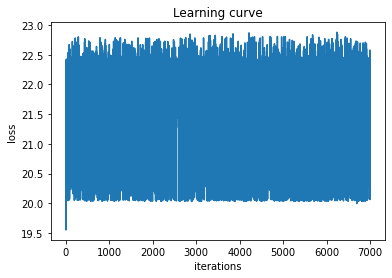

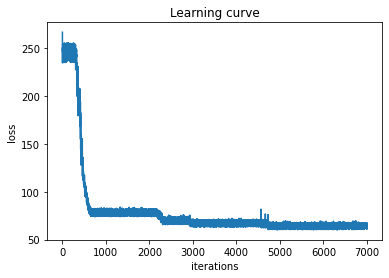

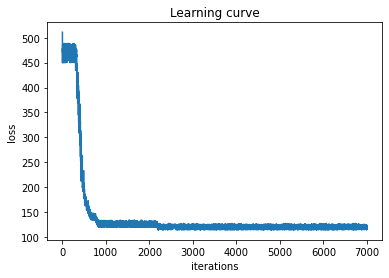

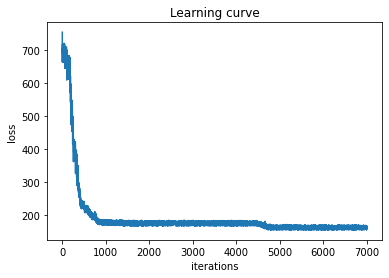

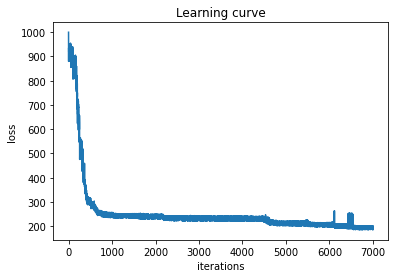

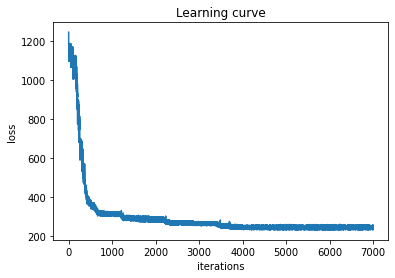

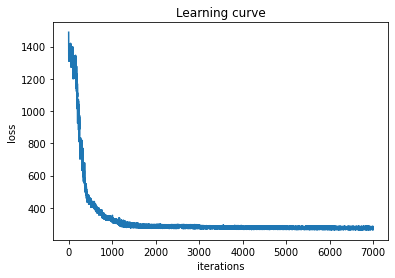

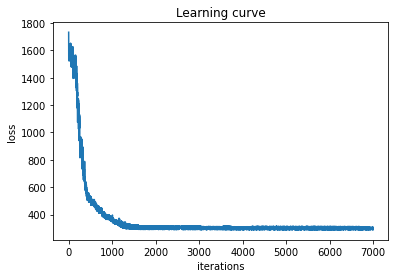

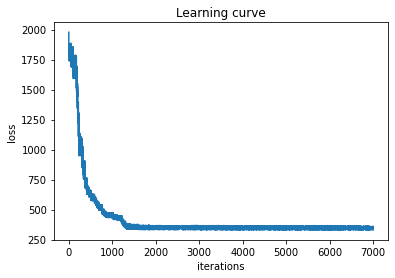

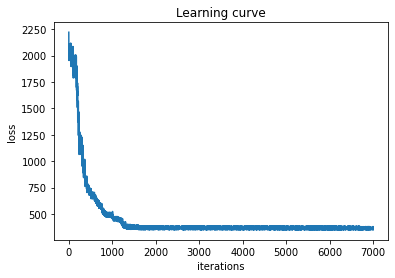

In [ ]:
for i in range(10):
    fig = plt.figure()
    plt.plot(np.arange(max_iter), result['loss'][i], label= "alpha="+str(result['alpha'][i]))
    plt.xlabel("iterations")
    plt.ylabel("loss")
    plt.title("Learning curve")
    plt.show()
    fig.savefig(path+"/size10000/"+"iter7000_4/a"+str(result['alpha'][i])+ "loss_10.png", dpi=fig.dpi)
    plt.close()

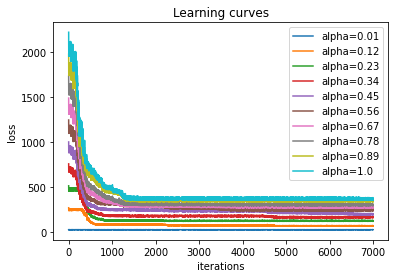

In [ ]:
fig = plt.figure()
for i in range(10):
    plt.plot(np.arange(max_iter), result['loss'][i], label= "alpha="+str(result['alpha'][i]))
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("Learning curves")
plt.legend()
plt.show()
fig.savefig(path+"/size10000/"+"iter7000_4/losses_merged_10.png", dpi=fig.dpi)
plt.close()

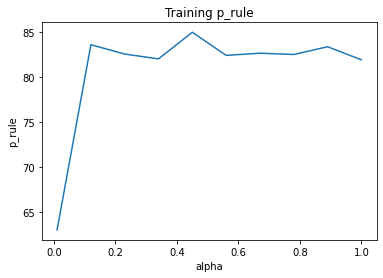

In [ ]:
fig = plt.figure()
plt.plot(result['alpha'], result['p_rule_train'])
plt.xlabel("alpha")
plt.ylabel("p_rule")
plt.title("Training p_rule")
plt.show()
fig.savefig(path+"/size10000/"+"iter7000_4/"+"training_p_rule_10.png", dpi=fig.dpi)
plt.close()

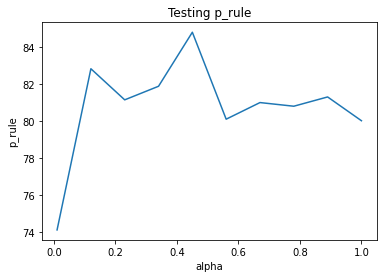

In [ ]:
fig = plt.figure()
plt.plot(result['alpha'], result['p_rule_test'])
plt.xlabel("alpha")
plt.ylabel("p_rule")
plt.title("Testing p_rule")
plt.show()
fig.savefig(path+"/size10000/"+"iter7000_4/"+"testing_p_rule_10.png", dpi=fig.dpi)
plt.close()

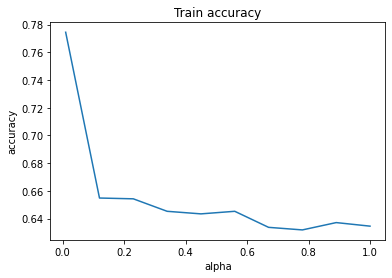

In [ ]:
fig = plt.figure()
plt.plot(result['alpha'], result['train_accuracy'])
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Train accuracy")
plt.show()
fig.savefig(path+"/size10000/"+"iter7000_4/"+"train_accuracies_10.png", dpi=fig.dpi)
plt.close()

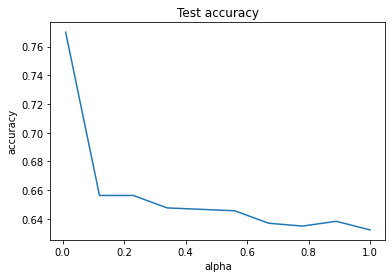

In [ ]:
fig = plt.figure()
plt.plot(result['alpha'], result['test_accuracy'])
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Test accuracy")
plt.show()
fig.savefig(path+"/size10000/"+"iter7000_4/"+"test_accuracies_10.png", dpi=fig.dpi)
plt.close()

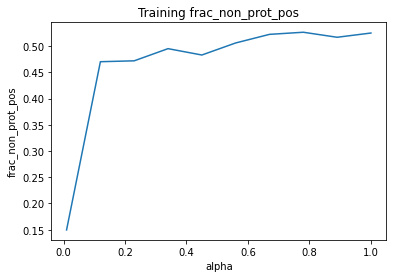

In [ ]:
fig = plt.figure()
plt.plot(result['alpha'], result['frac_non_prot_pos_train'])
plt.xlabel("alpha")
plt.ylabel("frac_non_prot_pos")
plt.title("Training frac_non_prot_pos")
plt.show()
fig.savefig(path+"/size10000/"+"iter7000_4/"+"frac_non_prot_pos_train_10.png", dpi=fig.dpi)
plt.close()

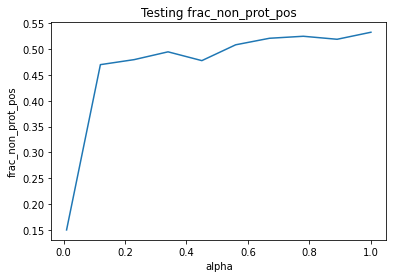

In [ ]:
fig = plt.figure()
plt.plot(result['alpha'], result['frac_non_prot_pos_test'])
plt.xlabel("alpha")
plt.ylabel("frac_non_prot_pos")
plt.title("Testing frac_non_prot_pos")
plt.show()
fig.savefig(path+"/size10000/"+"iter7000_4/"+"frac_non_prot_pos_test_10.png", dpi=fig.dpi)
plt.close()

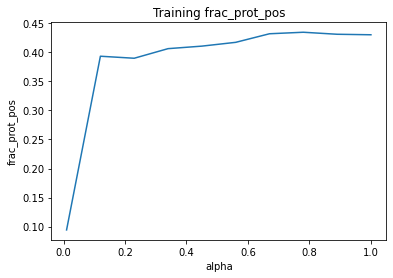

In [ ]:
fig = plt.figure()
plt.plot(result['alpha'], result['frac_prot_pos_train'])
plt.xlabel("alpha")
plt.ylabel("frac_prot_pos")
plt.title("Training frac_prot_pos")
plt.show()
fig.savefig(path+"/size10000/"+"iter7000_4/"+"frac_prot_pos_train_10.png", dpi=fig.dpi)
plt.close()

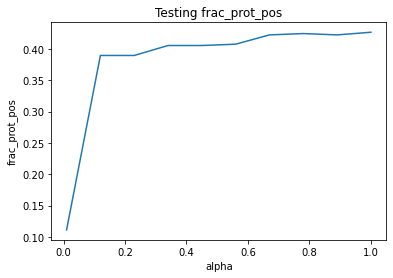

In [ ]:
fig = plt.figure()
plt.plot(result['alpha'], result['frac_prot_pos_test'])
plt.xlabel("alpha")
plt.ylabel("frac_prot_pos")
plt.title("Testing frac_prot_pos")
plt.show()
fig.savefig(path+"/size10000/"+"iter7000_4/"+"frac_prot_pos_test_10.png", dpi=fig.dpi)
plt.close()

In [ ]:
print(result['train_accuracy'])
print(result['test_accuracy'])

In [ ]:
c, loss, train_accuracy, test_accuracy, p_rule_train,\
                                                p_rule_test = train_test_classifier()
print("train accuracy: ", train_accuracy)
print("test accuracy: ", test_accuracy)
# print("c : ", c)
print("final loss: ", loss)
print("p rule train : ", p_rule_train)
print("p rule test: ", p_rule_test)

iter:  100 , lambda:  1 , alpha:  0.5 , kernel: rbf method:  cobyla , catol:  0.001 , initiator:  1e-05
c_init:  [[9.42248229e-06]
 [6.02018547e-06]
 [7.68290319e-06]
 ...
 [3.67490223e-07]
 [9.84391363e-06]
 [6.48007430e-06]]


KeyboardInterrupt: ignored

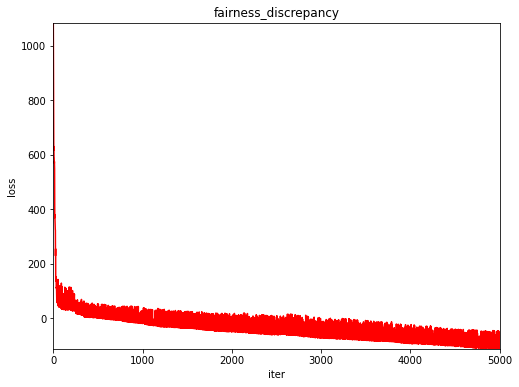

In [ ]:
plt.figure(figsize=(8,6))
plt.title('fairness_discrepancy')
plt.xlabel('iter')
plt.ylabel('loss')
plt.axis([0, max_iter, min(loss), max(loss)])
plt.plot([i for i in range(max_iter)], loss, 'r-')

In [ ]:
plt.savefig('test1.png', bbox_inches='tight', dpi=10)

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,6))
plt.title('simpleSVM')
plt.xlabel('data_size')
plt.ylabel('accuracy')
plt.plot(data_sizes.astype(int), train_accuracies, 'r-', data_sizes.astype(int), test_accuracies, 'b-')